In [371]:
import numpy as np
import pandas as pd
from scipy.linalg import fractional_matrix_power

In [372]:
def normalize_matrix(A: np.array) -> np.array:
    return (A - A.min(axis=1)[:,None]) / (A.max(axis=1)[:,None] - A.min(axis=1)[:,None])

In [373]:
def calculate_mean_and_covariance_matrices(X: np.array, Y: np.array) -> (np.array, np.array, np.array, np.array ,np.array):
    assert X.shape[1] == Y.shape[1]
    n = X.shape[1]
    return np.mean(X, axis=1), np.mean(Y, axis=1), np.dot(X, X.T) / n, np.dot(Y, X.T) / n, np.dot(Y, Y.T) / n

In [374]:
def reduced_rank_regression(X: np.array, Y: np.array, Gamma: np.array, t: int) -> (np.array, np.array, float):
    assert t <= Y.shape[0]
    assert Y.shape[0] <= X.shape[0]
    assert X.shape[1] == Y.shape[1]
    assert Gamma.shape == (Y.shape[0], Y.shape[0])
    mu_X, mu_Y, Sigma_XX, Sigma_YX, Sigma_YY = calculate_mean_and_covariance_matrices(X, Y)
    U, S, _ = np.linalg.svd(np.dot(np.dot(fractional_matrix_power(Gamma, 0.5), Sigma_YX), 
                                   fractional_matrix_power(Sigma_XX, -0.5)))
    C_min = np.dot(np.dot(np.dot(fractional_matrix_power(Gamma, -0.5), np.dot(U[:,0:t], U[:,0:t].T)), 
                   fractional_matrix_power(Gamma, 0.5)), np.dot(Sigma_YX, np.linalg.inv(Sigma_XX)))
    mu_min = mu_Y - np.dot(C_min, mu_X)
    min_value = np.trace(Sigma_YY) * np.trace(Gamma) - np.sum(S[0:t])
    return mu_min, C_min, min_value

In [375]:
wine_dataset = pd.read_csv("wine_dataset.csv")

In [376]:
X_variables = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
Y_variables = ['volatile acidity', 'fixed acidity', 'citric acid']
X = normalize_matrix(wine_dataset[X_variables].values.T)
Y = normalize_matrix(wine_dataset[Y_variables].values.T)

In [377]:
rrr_result_values = [reduced_rank_regression(X, Y, np.identity(Y.shape[0]), t) for t in range(Y.shape[0] + 1)]

In [378]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import *
%matplotlib inline

(3, 7)


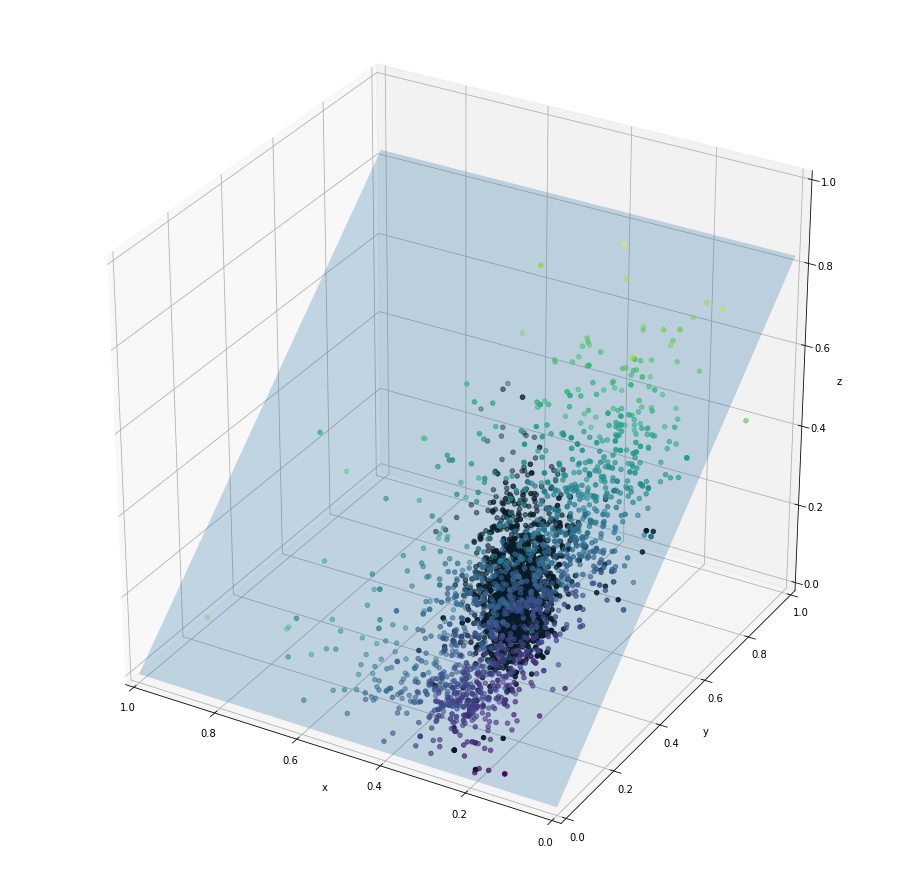

In [379]:
fig = plt.figure()
fig.set_size_inches(16, 16)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 1)
ax.invert_xaxis()

# Plotte die Datenpunkte
xpts, ypts, zpts = Y[0,:], Y[1,:], Y[2,:]
ax.scatter(xpts, ypts, zpts, c=np.linalg.norm(Y, axis=0))
ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_zlabel('z')

mu_min, C_min, _ = rrr_result_values[2]
print(C_min.shape)
predY = mu_min [:,None] + np.dot(C_min, X)
xpts, ypts, zpts = predY[0,:], predY[1,:], predY[2,:]
ax.scatter(xpts, ypts, zpts, c='black')

# Plotte mögliche Werte für die Approximation mit t=2
point, C_min, _ = rrr_result_values[2]
normal = np.cross(C_min[:,0], C_min[:,1])
d = -point.dot(normal)
xx, yy = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
z = (-normal[0] * xx - normal[1] * yy - d) / normal[2]
ax.plot_surface(xx, yy, z, alpha=0.25)